# An Analysis of the Degree of Difference between Music Genres

# 1. Load Data

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, tree, ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.classifier import ClassificationReport

%matplotlib inline

Get feature matrix of song metadata

In [2]:
import sqlite3
db = sqlite3.connect('Automatic Tagging/track_metadata.db')
songs = pd.read_sql_query("SELECT * from songs", db)

print("Song metadata shape: ", songs.shape)
print("Song metadata columns: ", songs.columns)

Song metadata shape:  (1000000, 11)
Song metadata columns:  Index(['track_id', 'title', 'song_id', 'release', 'artist_id', 'artist_mbid',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year'],
      dtype='object')


Get target matrix of music genres from AllMusic.com via http://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MASD-styleAssignment.cls

In [3]:
genres_cols = ['track_id','genre']
genres = pd.read_csv('Genre mapping 13.txt', sep='\t',header=None,names=genres_cols)

print("Genre data shape: ", genres.shape)
print("Genre data columns: ", genres.columns)

Genre data shape:  (406427, 2)
Genre data columns:  Index(['track_id', 'genre'], dtype='object')


Merge feature and target matrices

In [4]:
songs_w_genre = songs.merge(genres, on='track_id', how='inner')
print("Merged data shape: ", songs_w_genre.shape)
print("Merged data columns: ", songs_w_genre.columns)

Merged data shape:  (406427, 12)
Merged data columns:  Index(['track_id', 'title', 'song_id', 'release', 'artist_id', 'artist_mbid',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year', 'genre'],
      dtype='object')


# 2. Clean Data

Get column summary statistics

In [5]:
songs_w_genre.describe(include='all')

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,genre
count,406427,406427,406427,406427,406427,406427,406427,406427.000000,406427.000000,406427.000000,406427.000000,406427
unique,406427,314371,405959,53483,22300,20775,22614,NaN,NaN,NaN,NaN,13
top,TRKTCHC12903CF1521,Intro,SOUWROC12A8C141CF3,Classic Masters,AR6CLFP1187B9ACB94,,Daniel Johnston,NaN,NaN,NaN,NaN,Pop_Rock
freq,1,701,3,122,124,15001,124,NaN,NaN,NaN,NaN,238786
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.170439,0.583255,0.397316,1283.987895,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.312157,0.128301,0.117872,958.494905,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.495870,-1.000000,-1.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.637100,0.501873,0.348904,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232.567710,0.581444,0.397257,1995.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,288.234650,0.665133,0.456728,2004.000000,NaN


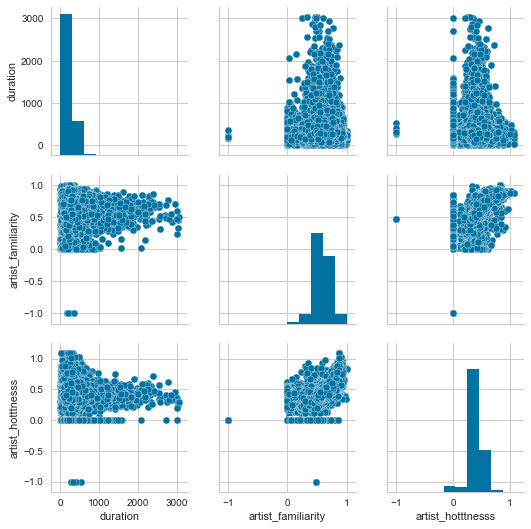

In [6]:
sns.pairplot(songs_w_genre, x_vars = ['duration','artist_familiarity','artist_hotttnesss'], 
             y_vars = ['duration','artist_familiarity','artist_hotttnesss'])

View songs with duplicate song_ids

In [7]:
songs_w_genre[songs_w_genre.duplicated(['song_id'], keep=False)].sort_values(by='song_id').head(6)

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,genre
57572,TRHELBK128F931F176,Fire And The Thud,SOACGAQ12A58A79805,Humbug,ARM0P6Z1187FB4D466,ada7a83c-e3e1-40f1-93f9-3e73dbc9298a,Arctic Monkeys,237.40036,0.816597,0.553661,2009,Pop_Rock
232955,TRTOJFP128F933897E,Fire And The Thud,SOACGAQ12A58A79805,Humbug,ARM0P6Z1187FB4D466,ada7a83c-e3e1-40f1-93f9-3e73dbc9298a,Arctic Monkeys,239.51628,0.816597,0.564911,2009,Pop_Rock
212569,TRPTLLT128F146D71A,Falling Into Grace (Album Version),SOADFGH12A6D4F74F7,One Hot Minute,ARE8GLF1187FB52532,8bfac288-ccc5-448d-9573-c33ea2aa5c30,Red Hot Chili Peppers,228.10077,0.833968,0.576904,1995,Pop_Rock
6062,TRMIGUO128F146D75D,Falling Into Grace (Album Version),SOADFGH12A6D4F74F7,One Hot Minute,ARE8GLF1187FB52532,8bfac288-ccc5-448d-9573-c33ea2aa5c30,Red Hot Chili Peppers,228.10077,0.833968,0.569765,1995,Pop_Rock
27843,TRWVWHQ128F148BF07,We Ride,SOADYVX12A8A9D9462,We Ride,ARKU3Z61187FB51DCA,73e5e69d-3554-40d8-8516-00cb38737a1c,Rihanna,236.64281,0.917864,0.944343,2006,Pop_Rock
266393,TREMTLA128F42B4F7A,We Ride,SOADYVX12A8A9D9462,We Ride,ARKU3Z61187FB51DCA,73e5e69d-3554-40d8-8516-00cb38737a1c,Rihanna,236.17261,0.917864,0.969246,2006,Pop_Rock


Drop songs with duplicate song_ids

In [8]:
songs_w_genre_clean = songs_w_genre.drop_duplicates('song_id')
print("Song_id count: ", songs_w_genre_clean['song_id'].count())
print("Song_id unique: ", songs_w_genre_clean['song_id'].nunique())

Song_id count:  405959
Song_id unique:  405959


Find additional possible duplicates on duration, artist_id, and year

In [9]:
songs_w_genre[songs_w_genre.duplicated(['duration','artist_name','year'], keep=False)].sort_values(by='duration').head(6)

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,genre
398408,TRYNITF128F422C478,Cavaquinho,SOEYURI12A81C22FA4,Sanfona,ARO81XD1187FB38096,2c9bfd68-38d2-4e9f-9baa-7f99ce7f2f79,Egberto Gismonti,1.20118,0.558759,0.397621,1981,Latin
289845,TRJTMNQ128F422C475,De Repente,SOHHGBI12A81C22F9F,Sanfona,ARO81XD1187FB38096,2c9bfd68-38d2-4e9f-9baa-7f99ce7f2f79,Egberto Gismonti,1.20118,0.558759,0.397621,1981,Latin
35823,TRGFAUU128F4262153,Snippet 16,SOQJRDF12AC9E156CD,Boo-Tay,ARRA2F91187B9B4061,7463fbd2-60fb-471a-a5cd-d42b75d72dad,Bare Jr.,3.99628,0.539381,0.360584,1998,Pop_Rock
277468,TRESCRR128F4262E7E,Snippet 18,SOABFYP12AC9E14F00,Boo-Tay,ARRA2F91187B9B4061,7463fbd2-60fb-471a-a5cd-d42b75d72dad,Bare Jr.,3.99628,0.539381,0.360584,1998,Pop_Rock
132754,TRQNTDQ128F4262E79,Snippet 9,SOENQUB12AC9DCB02B,Boo-Tay,ARRA2F91187B9B4061,7463fbd2-60fb-471a-a5cd-d42b75d72dad,Bare Jr.,3.99628,0.539381,0.360584,1998,Pop_Rock
158843,TRICISY128F4262141,Snippet 10,SOIQSUW12AC9E13F0F,Boo-Tay,ARRA2F91187B9B4061,7463fbd2-60fb-471a-a5cd-d42b75d72dad,Bare Jr.,3.99628,0.539381,0.360584,1998,Pop_Rock


Drop duplicates of duration, artist_id, and year (this drops a few non-duplicates too, but it's conservative to remove them)

In [10]:
songs_w_genre_clean2 = songs_w_genre_clean.drop_duplicates(['duration','artist_name','year'])
print("Song_id count: ", songs_w_genre_clean2['song_id'].count())

Song_id count:  404691


View distribution of genres in the data

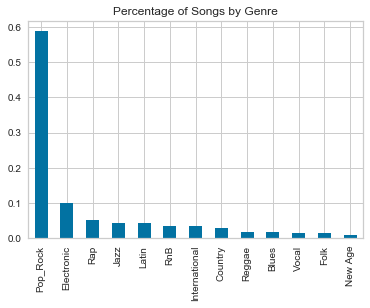

In [11]:
songs_w_genre_clean2['genre'].value_counts(normalize=True).plot(kind='bar')
plt.title('Percentage of Songs by Genre')

Most artists have only one genre

In [12]:
genres_per_artist = pd.DataFrame(songs_w_genre_clean2.groupby('artist_name')['genre'].nunique().reset_index())
genres_per_artist.rename(columns={'genre':'genre_count'}, inplace=True)

song_w_genre_clean_multgenre = songs_w_genre_clean2.merge(genres_per_artist, on='artist_name', how='left')
song_w_genre_clean_multgenre[song_w_genre_clean_multgenre['genre_count']>1].sort_values('artist_name').head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,genre,genre_count
102988,TRBUSOR128F9306AC8,Rette Mich Später,SOOQRUA12AB017FF62,Lasso,ARNJVSL1187B99AFD4,5579a23d-c411-4930-987d-ff89d77c1c12,2raumwohnung,235.72853,0.66456,0.39757,2009,Pop_Rock,2
338922,TRDSQRT128F424F98D,2 von millionen von Sternen (Clubversion),SOYJVSR12A8C13240B,Kommt zusammen Remix Album,ARNJVSL1187B99AFD4,5579a23d-c411-4930-987d-ff89d77c1c12,2raumwohnung,312.47628,0.66456,0.39757,2002,Electronic,2
193017,TRNZREB128F149AC37,Mir Kann Nichts Passieren,SOIEXTK12A6D4F7037,36 Grad,ARNJVSL1187B99AFD4,5579a23d-c411-4930-987d-ff89d77c1c12,2raumwohnung,238.07955,0.66456,0.39757,2007,Electronic,2
205072,TRPHMAQ128F428E2BE,Wir Sind Die Anderen (Ricardo Villalobos Remix),SOAZXDO12A8C13C37D,36 Grad Remixe,ARNJVSL1187B99AFD4,5579a23d-c411-4930-987d-ff89d77c1c12,2raumwohnung,768.83546,0.66456,0.39757,2005,Pop_Rock,2
16574,TRWWNGV128F424F990,Nimm mich mit (Jan Driver Remix),SOMTJDK12A8C132416,Kommt zusammen Remix Album,ARNJVSL1187B99AFD4,5579a23d-c411-4930-987d-ff89d77c1c12,2raumwohnung,321.20118,0.66456,0.39757,2000,Electronic,2


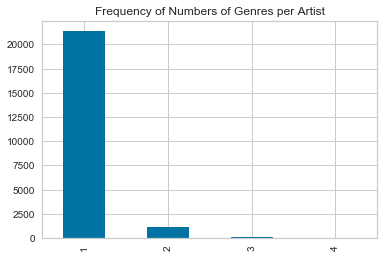

In [13]:
genres_per_artist['genre_count'].value_counts().plot(kind='bar')
plt.title('Frequency of Numbers of Genres per Artist')

Drop -1 values of artist_familiarity and artist_hotttnesss

In [14]:
print("Shape prior to drop:", songs_w_genre_clean2.shape)

Shape prior to drop: (404691, 12)


In [15]:
songs_w_genre_clean2[songs_w_genre_clean2['artist_familiarity']<0]

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,genre
4974,TRMQZZO128F92F83F5,Cicacicabum,SOCNJNA12AAF3B274E,El soneros,ARLYTLL122988F2B39,,Juan Carlos Vega,203.83302,-1.0,0.0,0,Latin
63564,TRCWSAY128F429AFFB,My Own_ My Only_ My All,SOZYYWJ12A8C13B5B2,Sings Songs Of Love,AR8LR0X1187FB4CCB7,06780d05-0b54-44a4-9fde-1307d5f9ced6,Monica Lewis,164.54485,-1.0,0.0,0,Vocal
80377,TRRHLHU128F92F8415,Amor pide amor,SOLUCMF12AAF3B596E,El soneros,ARLYTLL122988F2B39,,Juan Carlos Vega,178.75546,-1.0,0.0,0,Latin
99259,TRBZQRQ128F92F83D5,Alegria,SOCGRXU12AAF3B534E,El soneros,ARLYTLL122988F2B39,,Juan Carlos Vega,174.88934,-1.0,0.0,0,Latin
100058,TRBIEKG12903D01567,La feria de las flores,SOSBNZD12AC3DF573D,Jorge Negrete,ARORILY12420781766,,Jorge Negrete,170.31791,-1.0,0.0,0,Latin
103029,TRBULUN128F92F8421,Felicidad,SORYQOP12AAF3B59A2,El soneros,ARLYTLL122988F2B39,,Juan Carlos Vega,245.15873,-1.0,0.0,0,Latin
127311,TRQHPAQ128F92F8406,El sonador,SOLWETI12AAF3B5052,El soneros,ARLYTLL122988F2B39,,Juan Carlos Vega,186.35710,-1.0,0.0,0,Latin
158118,TRIHWJD128F92F83E4,Rubra,SOKVUMH12AAF3B26F5,El soneros,ARLYTLL122988F2B39,,Juan Carlos Vega,186.69669,-1.0,0.0,0,Latin
200451,TRNVLBV128F92F83EC,Escuela de amor,SOQKVJJ12AAF3B271F,El soneros,ARLYTLL122988F2B39,,Juan Carlos Vega,227.78730,-1.0,0.0,0,Latin
255808,TRLQKIL128F92F8429,Guitarrita,SOKFYQY12AAF3B59BF,El soneros,ARLYTLL122988F2B39,,Juan Carlos Vega,168.61995,-1.0,0.0,0,Latin


In [16]:
songs_w_genre_clean[songs_w_genre_clean['artist_hotttnesss']<0]

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,genre
10866,TRMEKOI128F9308BAE,Malta,SOFQLYJ12AB01812F9,Directions,ARYGMNK1187B998FFE,84c27b03-1325-40c3-bb68-6b0cb820e1e4,Directions,296.41098,0.479841,-1.0,0,Pop_Rock
110718,TRFGBHF128F9308BA6,Our Portrait,SOKZMLJ12AB01812D7,Directions,ARYGMNK1187B998FFE,84c27b03-1325-40c3-bb68-6b0cb820e1e4,Directions,269.60934,0.479841,-1.0,0,Pop_Rock
214930,TRPJAXD128F9308BB0,You Can Hear The Sound,SOMMJKC12AB01812FF,Directions,ARYGMNK1187B998FFE,84c27b03-1325-40c3-bb68-6b0cb820e1e4,Directions,322.08934,0.479841,-1.0,0,Pop_Rock
245248,TRUEZDG128F9308BA4,Cinq_ Rouge_ Impair,SOQTRPQ12AB01812CD,Directions,ARYGMNK1187B998FFE,84c27b03-1325-40c3-bb68-6b0cb820e1e4,Directions,349.57016,0.479841,-1.0,0,Pop_Rock
260058,TRLLWNY128F9308B9D,Talking About Sonny,SOLMWUS12AB01813B4,Directions,ARYGMNK1187B998FFE,84c27b03-1325-40c3-bb68-6b0cb820e1e4,Directions,332.32934,0.479841,-1.0,0,Pop_Rock
299150,TRSHIBE128F9308BAB,Who Loves Ya,SORXLGD12AB01812E9,Directions,ARYGMNK1187B998FFE,84c27b03-1325-40c3-bb68-6b0cb820e1e4,Directions,529.57995,0.479841,-1.0,0,Pop_Rock
302212,TRSQLLG128F9308B9E,Dummy Funk,SOMPYUO12AB01813B9,Directions,ARYGMNK1187B998FFE,84c27b03-1325-40c3-bb68-6b0cb820e1e4,Directions,397.08689,0.479841,-1.0,0,Pop_Rock
337164,TRDTZTB128F9308BA8,Bassix,SONOXGW12AB01812DA,Directions,ARYGMNK1187B998FFE,84c27b03-1325-40c3-bb68-6b0cb820e1e4,Directions,282.01751,0.479841,-1.0,0,Pop_Rock
360375,TRXMOCG128F9308BA1,Coconuts Girl,SOLUFGC12AB01812C1,Directions,ARYGMNK1187B998FFE,84c27b03-1325-40c3-bb68-6b0cb820e1e4,Directions,320.91383,0.479841,-1.0,0,Pop_Rock


In [17]:
songs_w_genre_clean2 = songs_w_genre_clean2[songs_w_genre_clean2['artist_familiarity'] >= 0]
songs_w_genre_clean2 = songs_w_genre_clean2[songs_w_genre_clean2['artist_hotttnesss'] >= 0]
print("Shape with -1s dropped: ",songs_w_genre_clean2.shape)

Shape with -1s dropped:  (404669, 12)


# 3. Feature Engineering

In [18]:
songs_w_genre_clean2['artist_length'] = songs_w_genre_clean2['artist_name'].str.len()
songs_w_genre_clean2['title_length'] = songs_w_genre_clean2['title'].str.len()
songs_w_genre_clean2['release_length'] = songs_w_genre_clean2['release'].str.len()

# 4. Exploratory Analysis

Group data by artist for the purpose of predicting an artist's genre

In [19]:
artist_genres = pd.DataFrame(songs_w_genre_clean2.groupby('artist_name')['genre'].
                             agg(lambda x: x.value_counts().index[0]).reset_index())

In [20]:
artist_features = pd.DataFrame(songs_w_genre_clean2.groupby('artist_name').
                               agg({'duration':'median','artist_familiarity':'mean','artist_hotttnesss':'mean',
                                    'artist_length':'mean','title_length':'mean','release_length':'mean'}).
                               reset_index())

In [21]:
artist_data = artist_features.merge(artist_genres, on='artist_name', how='inner')

print("Merged data shape: ", artist_data.shape)
print("Merged data columns: ", artist_data.columns)

Merged data shape:  (22612, 8)
Merged data columns:  Index(['artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'artist_length', 'title_length', 'release_length', 'genre'],
      dtype='object')


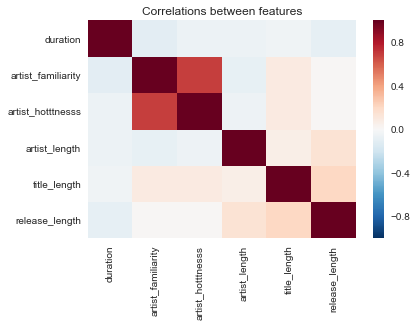

In [22]:
sns.heatmap(artist_data.corr()) # plot the heatmap
plt.title('Correlations between features')

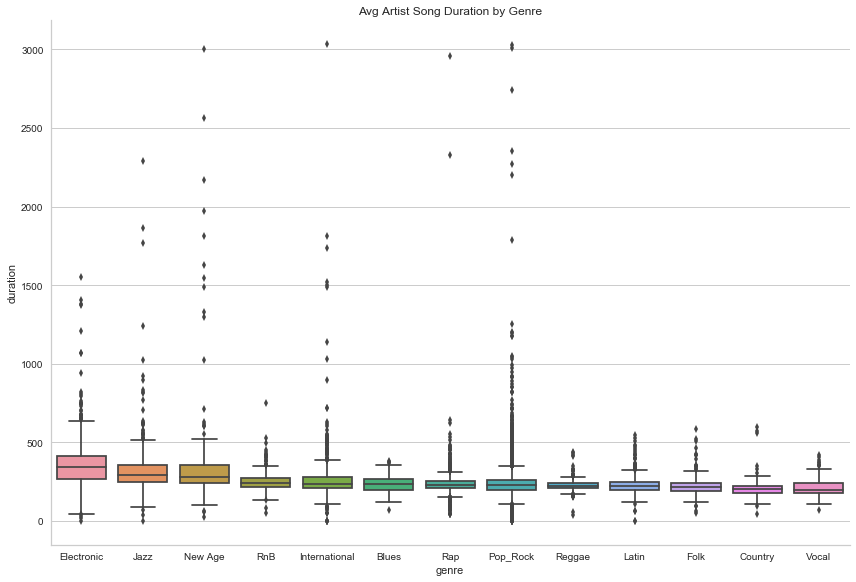

In [23]:
ranks = artist_data.groupby('genre')['duration'].median().fillna(0).sort_values()[::-1].index
sns.factorplot(kind='box', y='duration', x='genre', data=artist_data, size=8, aspect=1.5, order = ranks)
plt.title('Avg Artist Song Duration by Genre')

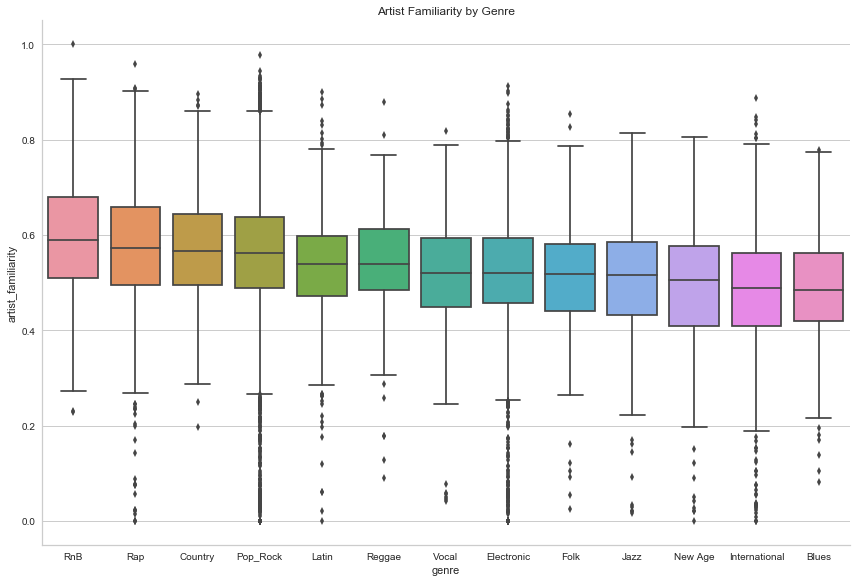

In [24]:
ranks = artist_data.groupby('genre')['artist_familiarity'].median().fillna(0).sort_values()[::-1].index
sns.factorplot(kind='box', y='artist_familiarity', x='genre', data=artist_data, size=8, aspect=1.5, order = ranks)
plt.title('Artist Familiarity by Genre')

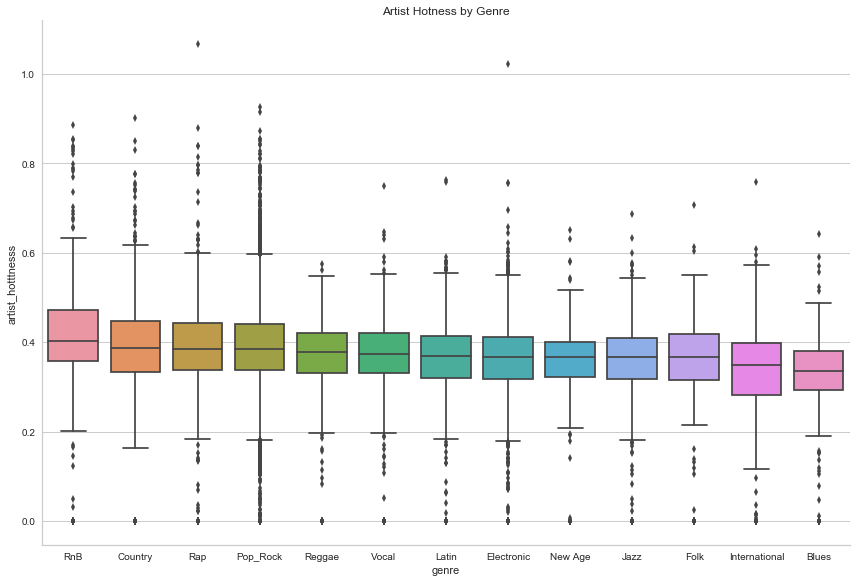

In [25]:
ranks = artist_data.groupby('genre')['artist_hotttnesss'].median().fillna(0).sort_values()[::-1].index
sns.factorplot(kind='box', y='artist_hotttnesss', x='genre', data=artist_data, size=8, aspect=1.5, order = ranks)
plt.title('Artist Hotness by Genre')

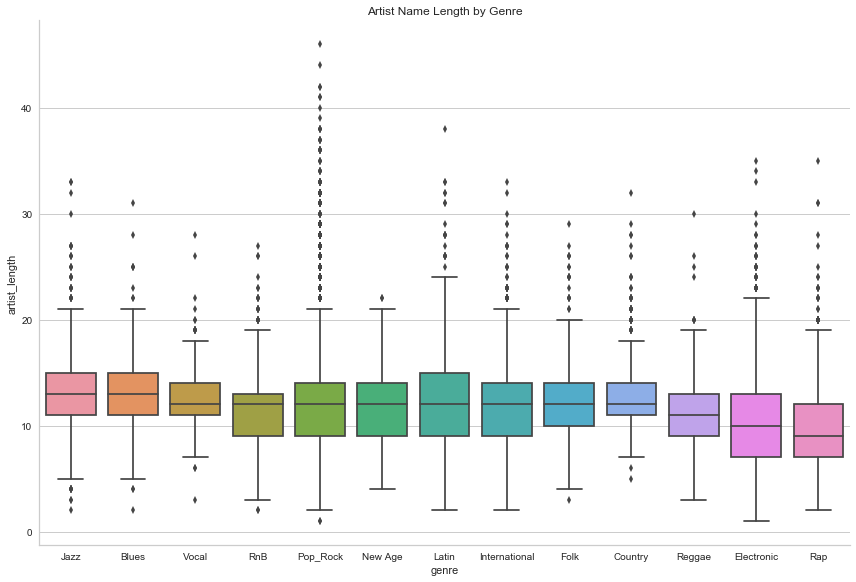

In [26]:
ranks = artist_data.groupby('genre')['artist_length'].median().fillna(0).sort_values()[::-1].index
sns.factorplot(kind='box', y='artist_length', x='genre', data=artist_data, size=8, aspect=1.5, order = ranks)
plt.title('Artist Name Length by Genre')

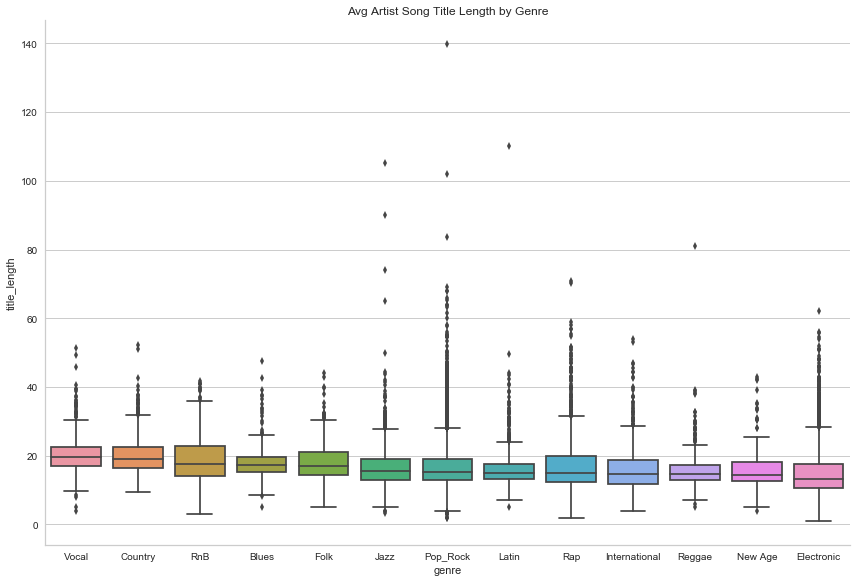

In [27]:
ranks = artist_data.groupby('genre')['title_length'].median().fillna(0).sort_values()[::-1].index
sns.factorplot(kind='box', y='title_length', x='genre', data=artist_data, size=8, aspect=1.5, order = ranks)
plt.title('Avg Artist Song Title Length by Genre')

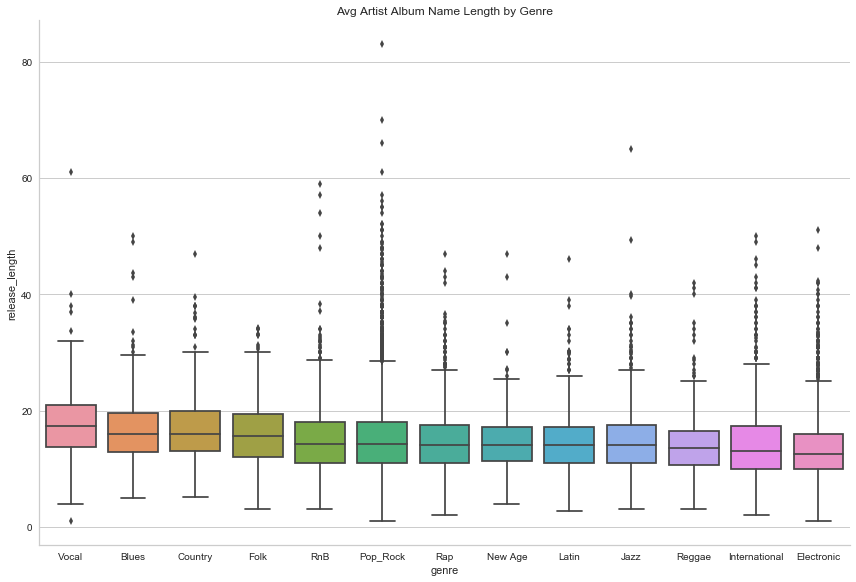

In [28]:
ranks = artist_data.groupby('genre')['release_length'].median().fillna(0).sort_values()[::-1].index
sns.factorplot(kind='box', y='release_length', x='genre', data=artist_data, size=8, aspect=1.5, order = ranks)
plt.title('Avg Artist Album Name Length by Genre')

# 5. Model to predict an artist's genre

There aren't many features, but there are a lot of genres, so let's simplify by trying to predict whether an artist's genre is pop rock or not.

In [29]:
artist_data['genre_elect'] = pd.DataFrame(artist_data['genre'] == 'Pop_Rock')
artist_data['genre_elect'].replace({True:'Pop_Rock',False:'Not Pop_Rock'}, inplace = True)

Get null accuracy

In [30]:
artist_data['genre_elect'].value_counts(normalize=True)

Pop_Rock        0.543517
Not Pop_Rock    0.456483
Name: genre_elect, dtype: float64

Define X and Y for modeling

In [31]:
song_features = ['duration','artist_familiarity','artist_hotttnesss','artist_length','title_length','release_length']
X = artist_data[song_features]
y = artist_data['genre_elect']

Train-Test Split

In [32]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

Run Random Forest Classifier model

In [39]:
rf = RandomForestClassifier(n_estimators=30)
rf.fit(X_train, y_train)
y_preds = rf.predict(X_test)
print("Test set accuracy: ", metrics.accuracy_score(y_test, y_preds))
print("Test set metrics:\n",metrics.classification_report(y_test,y_preds))

Test set accuracy:  0.622346698113
Test set metrics:
               precision    recall  f1-score   support

Not Pop_Rock       0.59      0.55      0.57      3093
    Pop_Rock       0.65      0.68      0.66      3691

 avg / total       0.62      0.62      0.62      6784



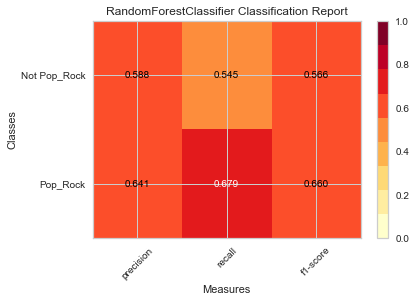

In [40]:
visualizer = ClassificationReport(rf) # Instantiate the visualizer
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

Random forest was only mildly successful at predicting whether an artist's genre is Pop Rock or not (62% accuracy vs 54% null accuracy). I need to add additional features to my model to increase its accuracy. However, we can learn about the relative feature importances from the random forest model:

In [41]:
pd.DataFrame({'feature':song_features, 'importance':rf.feature_importances_}).sort_values(by='importance',ascending=False)

,feature,importance
0,duration,0.239050
1,artist_familiarity,0.176613
4,title_length,0.170976
2,artist_hotttnesss,0.166703
5,release_length,0.147983
3,artist_length,0.098676


# 6. Visualization of distance between genres

We can visualize the distance between genres by graphing the genre's feature averages, scaling, and reducing to 2D using PCA.

In [42]:
genre_stats = pd.DataFrame(artist_data.groupby('genre').
                           agg({'duration':'median','artist_familiarity':'mean','artist_hotttnesss':'mean',
                                'artist_length':'mean','title_length':'mean','release_length':'mean'}).reset_index())

In [43]:
genre_stats_x = genre_stats.drop('genre', axis=1)

In [44]:
scaler = StandardScaler() #create a scaler object
scaler.fit(genre_stats_x) #fit the scaler
genre_stats_x_scaled = scaler.transform(genre_stats_x) #transform the training data with it

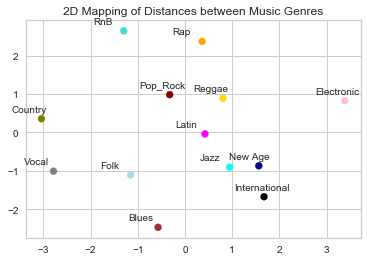

In [47]:
#plotting the clusters using PCA to get a 2D graph
pca = PCA(n_components=2) #2-dimensional PCA
y_pca = pd.DataFrame(pca.fit_transform(genre_stats_x_scaled))

#first we need to map colors on labels
dfcolor = pd.DataFrame([['Pop_Rock','maroon'],['Electronic','pink'],['Rap','orange'],['Jazz','cyan'],
                        ['Latin','magenta'],['RnB','turquoise'],['International','black'],['Country','olive'],
                        ['Reggae','gold'],['Blues','brown'],['Vocal','grey'],['Folk','lightblue'],['New Age','navy']],
                       columns=['genre','color'])
mergeddf = pd.merge(genre_stats,dfcolor,on='genre')

#then we do the graph
plt.scatter(y_pca[0],y_pca[1],color=mergeddf['color'])

#add labels
for label, x, y in zip(mergeddf['genre'], y_pca[0], y_pca[1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-30, 7),
        textcoords= 'offset points')

plt.title('2D Mapping of Distances between Music Genres')    
plt.show()

# 7. Chord diagram based on number of common listeners between genres

Get user data

In [48]:
cols = ['user_id','song_id','play_count']
user_data = pd.read_csv('User Data/kaggle_visible_evaluation_triplets.txt', sep = '\t', header=None, names=cols)

print('User data shape', user_data.shape)

User data shape (1450933, 3)


Merge with track_id

In [49]:
user_data_w_track_id = user_data.merge(songs, on='song_id', how='inner')

print('User data w track id shape:', user_data_w_track_id.shape)

User data w track id shape: (1491952, 13)


Merge with genre

In [50]:
user_data_w_genre = user_data_w_track_id.merge(genres, on='track_id', how='inner')

print('User data w genre shape: ', user_data_w_genre.shape)

User data w genre shape:  (732777, 14)


In [51]:
clean_user_data_w_genre = user_data_w_genre[['user_id','play_count','genre']]

Calculate user-genre pairs, considering a pair to be any genre which comprises at least 20% of the user's listening

In [53]:
collapsed_user_data = pd.DataFrame(clean_user_data_w_genre.groupby(['user_id','genre'])['play_count'].sum())
print('Collapsed user data shape: ', collapsed_user_data.shape)

Collapsed user data shape:  (229040, 1)


In [54]:
collapsed_user_pcts = pd.DataFrame(collapsed_user_data.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index())

In [55]:
collapsed_user_20_pct = collapsed_user_pcts[collapsed_user_pcts['play_count']>20]

In [56]:
collapsed_user_20_pct['play_count'] = 1

C:\Users\azimmermann\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Calculate number of connections between genres

In [57]:
user_pivot = collapsed_user_20_pct.pivot(index='user_id', columns='genre', values='play_count')
user_pivot.head()

genre,Blues,Country,Electronic,Folk,International,Jazz,Latin,New Age,Pop_Rock,Rap,Reggae,RnB,Vocal
user_id,,,,,,,,,,,,,
00007a02388c208ea7176479f6ae06f8224355b3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
00014a76ed063e1a749171a253bca9d9a0ff1782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
00015189668691680bb1a2e58afde1541ec92ced,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
0001ff7aa2667c8d8b945317b88adaed1c0b9dc2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
00020fcd8b01986a6a85b896ccde6c49f35142ad,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [58]:
user_pivot['missing'] = user_pivot.isnull().sum(axis=1)

Drop if user only has one genre

In [59]:
user_mult_gen = user_pivot[user_pivot['missing']<12]

In [60]:
user_mult_gen.drop('missing', axis=1, inplace=True)

C:\Users\azimmermann\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [61]:
import itertools
pairwise_genres = pd.DataFrame({'{}-{}'.format(a, b): user_mult_gen[a] + user_mult_gen[b] for a, b in itertools.combinations(user_mult_gen.columns, 2)})

In [62]:
pairwise_genres.head()

,Blues-Country,Blues-Electronic,Blues-Folk,Blues-International,Blues-Jazz,Blues-Latin,Blues-New Age,Blues-Pop_Rock,Blues-Rap,Blues-Reggae,...,Pop_Rock-Rap,Pop_Rock-Reggae,Pop_Rock-RnB,Pop_Rock-Vocal,Rap-Reggae,Rap-RnB,Rap-Vocal,Reggae-RnB,Reggae-Vocal,RnB-Vocal
user_id,,,,,,,,,,,,,,,,,,,,,
00020fcd8b01986a6a85b896ccde6c49f35142ad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0003798d61a8010dbfd8010180b7107cbbb8a649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0003d5245414b9c6244046543a06f601bfc97949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00040e91f2f614ca2f94ebc558dd0fc53ea2b875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0004dd6499e2e3f630f070416c437627de60d5c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
pairwise_long = pd.melt(pairwise_genres)
pairwise_long_clean = pairwise_long[pairwise_long['value']>0]
pairwise_collapsed = pd.DataFrame(pairwise_long.groupby('variable').count().reset_index())

In [64]:
pairwise_collapsed.head()

,variable,value
0,Blues-Country,16
1,Blues-Electronic,35
2,Blues-Folk,5
3,Blues-International,9
4,Blues-Jazz,10


In [65]:
pairwise_collapsed['genre1'], pairwise_collapsed['genre2'] = pairwise_collapsed['variable'].str.split('-', 1).str

In [66]:
pairwise_collapsed['reduced_value'] = pairwise_collapsed['value'] / 250 
pairwise_collapsed['rounded_reduced'] = pairwise_collapsed['reduced_value'].round(0)

In [67]:
from bokeh.charts import output_notebook, Chord
from bokeh.io import show

chord_from_df = Chord(pairwise_collapsed, source="genre1", target="genre2", value="rounded_reduced")
output_notebook()
show(chord_from_df)

Loading BokehJS ...

# 8. Further Work

Primarily, the model and visualizations above can be improved by adding additional features.

Additionally, here are some tasks for me to consider: <br>
1) Do I need to address the imbalance between the classes? <br>
2) Add additional genres from other available genre datasets, especially to the chord diagram <br>
3) Double check for missing values and clean up treatment of them <br>
4) Add more comments and clean up the dataset names <br>
5) Examine KNN's performance on the testing data for varying values of k <br>
6) Tune model parameters <br>
7) Plot AUC <br>
8) Additional feature engineering <br>
9) Find out how artist_familiarity and artist_hotttnesss are calculated <br>
10) Check if artist_name is unique - maybe use ID instead <br>
11) Are the issues if my features are too multi-collinear?
12) Add genre size based on share to 2D plot
13) Clean up GitHub repository

# 9. Archive of Unused Code

In [ ]:
#import h5py
#filename = 'https://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/msd_summary_file.h5'
#f = h5py.File(filename, 'r')

#import hdf5_getters
#h5 = hdf5_getters.open_h5_file_read('https://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/msd_summary_file.h5')
#duration = hdf5_getters.get_duration(h5)
#h5.close()

#import hdf5_getters
#h5 = hdf5_getters.open_h5_file_read("C:/Users/azimmermann/Desktop/Music Genre Viz/MillionSongSubset/AdditionalFiles/subset_msd_summary_file.h5")

#df = pd.read_csv('https://github.com/Taranveer/Million_Song_dataset/blob/master/song_dataset.csv')

Scale features and run KNN model

In [ ]:
scaler = StandardScaler() #create a scaler object
scaler.fit(X_train) #fit the scaler
X_train_scaled = scaler.transform(X_train) #transform the training data with it
X_test_scaled = scaler.transform(X_test) #transform the testing data with it

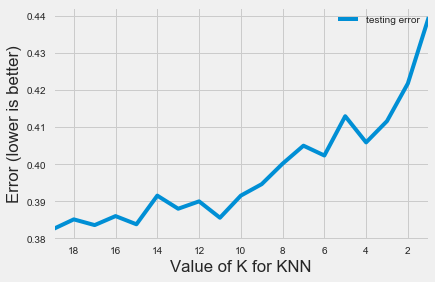

In [304]:
k_range = range(1, 20)
testing_error = []

for k in k_range:
    knn_ss = KNeighborsClassifier(n_neighbors=k)
    knn_ss.fit(X_train_scaled, y_train)
    y_preds = knn_ss.predict(X_test_scaled)
    testing_accuracy = metrics.accuracy_score(y_test, y_preds)
    testing_error.append(1 - testing_accuracy)

plt.style.use('fivethirtyeight')
# create a DataFrame of K, training error, and testing error
column_dict = {'K': k_range, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
# plot the relationship between K (HIGH TO LOW) and TESTING ERROR
df.plot(y='testing error')
plt.xlabel('Value of K for KNN')
plt.ylabel('Error (lower is better)')

In [305]:
knn_ss = KNeighborsClassifier(n_neighbors=11)
knn_ss.fit(X_train_scaled, y_train)
y_preds = knn_ss.predict(X_test_scaled)
print("Test set accuracy:",metrics.accuracy_score(y_test, y_preds))
print("Test set metrics:\n",metrics.classification_report(y_test,y_preds))

Test set accuracy: 0.614415211143
Test set metrics:
                 precision    recall  f1-score   support

    Electronic       0.62      0.72      0.67      2427
Not Electronic       0.60      0.49      0.54      2096

   avg / total       0.61      0.61      0.61      4523

